In [1]:
from collections import OrderedDict
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim

import sys
sys.path.append('/home/dominhnhat/Classroom/deepul')
from deepul.hw2_helper import *


import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import transforms
import matplotlib.pyplot as plt
import torch.nn.functional as F

In [2]:


class MyImageDataset(Dataset):
    def __init__(self, image_dir, transform=None):
        self.image_dir = image_dir
        self.image_files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
        self.transform = transform

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.image_dir, self.image_files[idx])
        image = Image.open(img_path).convert("RGB")
        
        if self.transform:
            image = self.transform(image)
            
        return image

transform = transforms.Compose([
    transforms.ToTensor(),
])

data_dir = '/home/dominhnhat/Classroom/deepul/VAE-images/train'
dataset = MyImageDataset(image_dir=data_dir, transform=transform)

train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=False)


torch.Size([128, 3, 32, 32])
torch.Size([3, 32, 32])
tensor([[[0.4039, 0.4157, 0.3961,  ..., 0.3490, 0.3255, 0.3098],
         [0.4549, 0.4275, 0.4627,  ..., 0.3451, 0.3294, 0.2941],
         [0.3412, 0.3451, 0.4431,  ..., 0.3294, 0.3294, 0.3020],
         ...,
         [0.3882, 0.3922, 0.4353,  ..., 0.4431, 0.4235, 0.4000],
         [0.3804, 0.3804, 0.4157,  ..., 0.4431, 0.4235, 0.4157],
         [0.3961, 0.4039, 0.4000,  ..., 0.4314, 0.4235, 0.4196]],

        [[0.3137, 0.3216, 0.2902,  ..., 0.2627, 0.2471, 0.2314],
         [0.3451, 0.3098, 0.3373,  ..., 0.2471, 0.2471, 0.2235],
         [0.2275, 0.2196, 0.3098,  ..., 0.2196, 0.2392, 0.2353],
         ...,
         [0.2667, 0.2784, 0.3020,  ..., 0.2471, 0.2588, 0.2471],
         [0.2549, 0.2588, 0.2863,  ..., 0.2510, 0.2510, 0.2549],
         [0.2510, 0.2510, 0.2667,  ..., 0.2549, 0.2588, 0.2588]],

        [[0.2784, 0.2745, 0.2392,  ..., 0.2000, 0.1961, 0.2078],
         [0.3176, 0.2745, 0.2941,  ..., 0.1843, 0.2000, 0.1961],
     

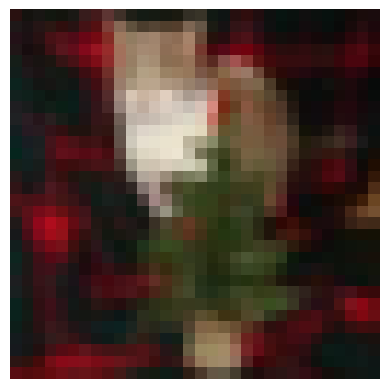

In [3]:
for images in train_dataloader:
    print(images.shape)
    for image in images:
        print(image.shape)
        print(image)

        img_numpy = images[1].permute(1,2,0).numpy()
        plt.imshow(img_numpy)
        plt.axis('off')  # Turn off axis labels
        plt.show()  

        break
    break

In [4]:
class Encoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.net = nn.Sequential(
            nn.Conv2d(3, 32, 3, 1, 1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, 2, 1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, 2, 1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(4 * 4 * 256, 2 * latent_dim)
        ) 

    def forward(self, x):
        return self.net(x).view(x.shape[0], -1)      

class Decoder(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.fc = nn.Sequential(
            nn.Linear(latent_dim, 4 * 4 * 128),
            nn.ReLU(),
        ) 

        self.net = nn.Sequential(
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, 1, 1),
        ) 

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.shape[0], 128, 4, 4)
        return self.net(x)

class VAE(nn.Module):
    def __init__(self, latent_dim):
        super().__init__()
        self.latent_dim = latent_dim

        self.encoder = Encoder(latent_dim)
        self.decoder = Decoder(latent_dim)

    def loss(self, x):
        mu_z, log_std_z = self.encoder(x).chunk(2, dim = 1)
        z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
        x_recon = self.decoder(z)

        recon_loss = F.mse_loss(x, x_recon, reduction='none').view(x.shape[0], -1).sum(1).mean()

        kl_loss = -log_std_z - 0.5 + (torch.exp(2 * log_std_z) + mu_z ** 2) * 0.5
        kl_loss = kl_loss.sum(1).mean()

        return OrderedDict(loss=recon_loss + kl_loss, recon_loss=recon_loss,
                           kl_loss=kl_loss)

    def sample(self, n):
        with torch.no_grad():
            z = torch.randn(n, self.latent_dim).cuda()
            samples = torch.clamp(self.decoder(z), 0, 1)
            return samples.cpu().permute(0, 2, 3, 1).numpy()

def evaluate_test_loss(model, dataloader):
    model.eval()
    elbo_loss, recon_loss, kl_loss = [], [], []
    for x in dataloader:
        x = x.cuda()
        out = model.loss(x)

        elbo_loss.append(out['loss'].item())
        recon_loss.append(out['recon_loss'].item())
        kl_loss.append(out['kl_loss'].item())
    
    print(np.mean(elbo_loss), np.mean(recon_loss), np.mean(kl_loss))
    return np.mean(elbo_loss), np.mean(recon_loss), np.mean(kl_loss)

def train_1_epoch(epoch_num, model, optimizer, dataloader, show_result = True):
    model.train()

    print(f'epoch number {epoch_num}' + '-'*30)
    elbo_loss, recon_loss, kl_loss = [], [], []
    for batch, X in enumerate(dataloader):
        X = X.cuda()
        out = model.loss(X)
        optimizer.zero_grad()

        out['loss'].backward()

        if (show_result == True and batch % 100 == 0):
            print(f"Batch Elbo loss :{out['loss'].item()} | Batch Recon loss : {out['recon_loss'].item()} | Batch KL loss : {out['kl_loss'].item()}")

        elbo_loss.append(out['loss'].item())
        recon_loss.append(out['recon_loss'].item())
        kl_loss.append(out['kl_loss'].item())
        optimizer.step()
    
    if (show_result == True):
        print(np.mean(elbo_loss), np.mean(recon_loss), np.mean(kl_loss))
    return np.mean(elbo_loss), np.mean(recon_loss), np.mean(kl_loss)

def train(model, optimizer, train_data, test_data):
    train_losses, test_losses = [], []
    for epoch in range(epochs):
        train_loss = train_1_epoch(epoch, model, optimizer, train_data)
        test_loss = evaluate_test_loss(model, test_data)
        train_losses.append(np.array(train_loss))
        test_losses.append(np.array(test_loss))

model = VAE(latent_dim=16).cuda()
optimizer = optim.Adam(model.parameters(), lr=3e-5)
epochs = 300

model.load_state_dict(torch.load('model_vae.pth'))

#train(model, optimizer, train_dataloader, test_dataloader)

#torch.save(model.state_dict(), "model_vae.pth")

<All keys matched successfully>

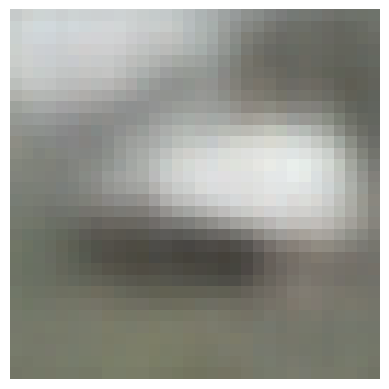

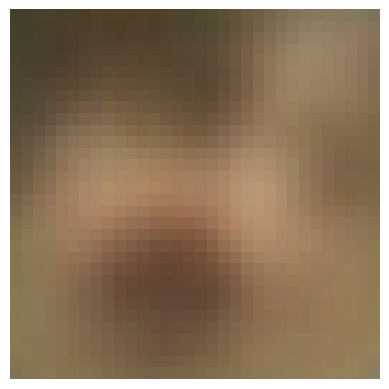

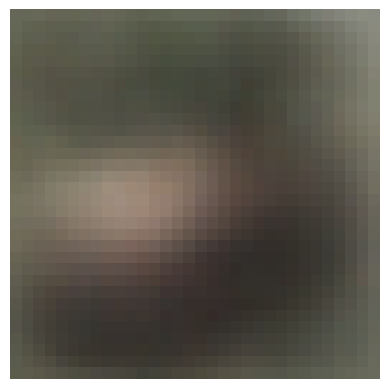

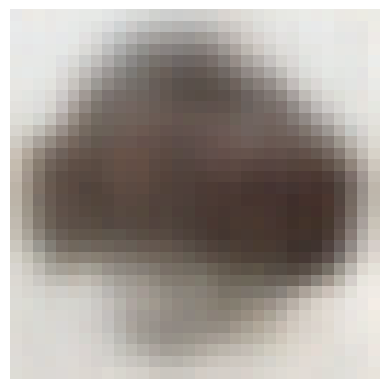

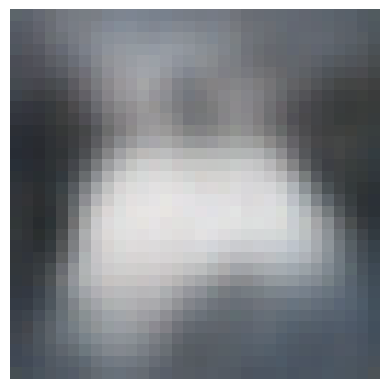

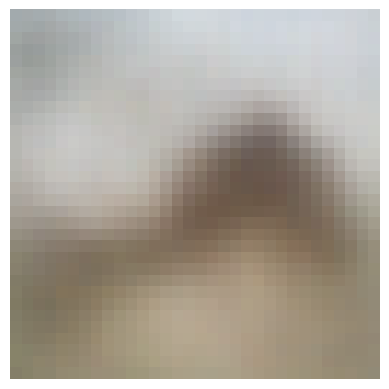

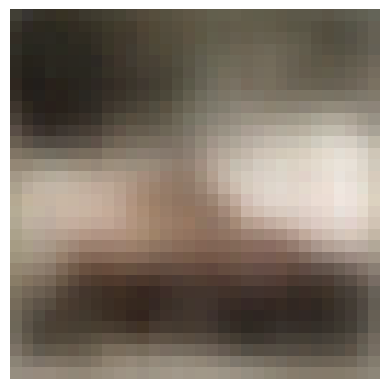

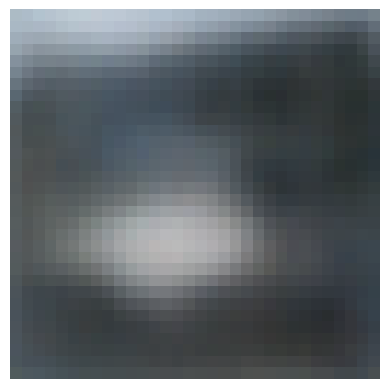

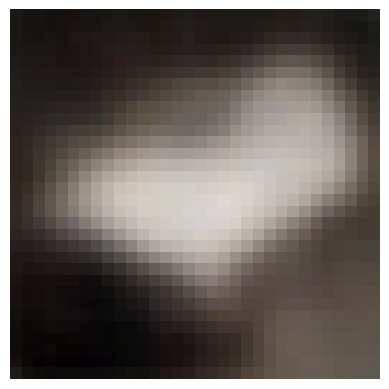

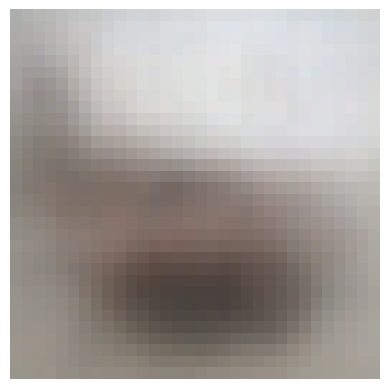

In [5]:
#sampling
generated_images = model.sample(10)
for image in generated_images:
    plt.imshow(image)
    plt.axis('off')  # Turn off axis labels
    plt.show()
    #break

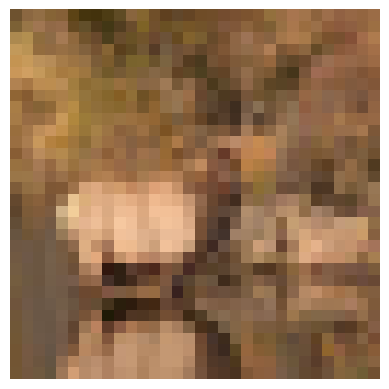

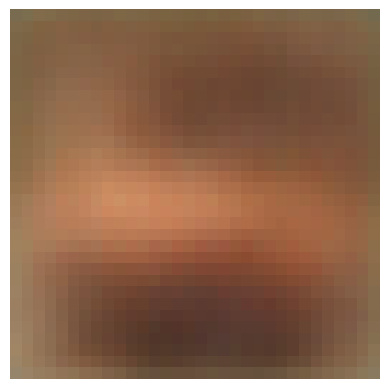

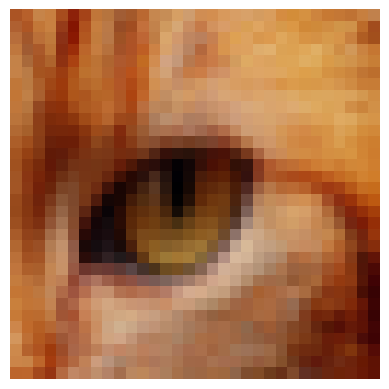

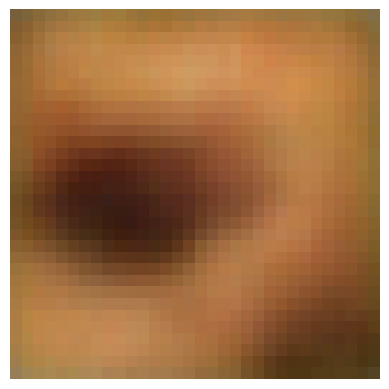

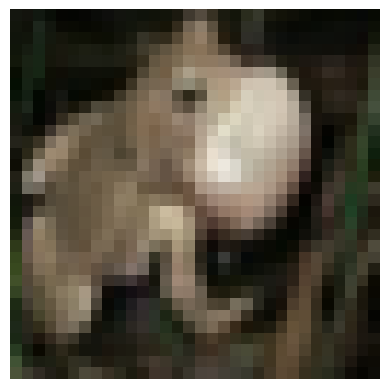

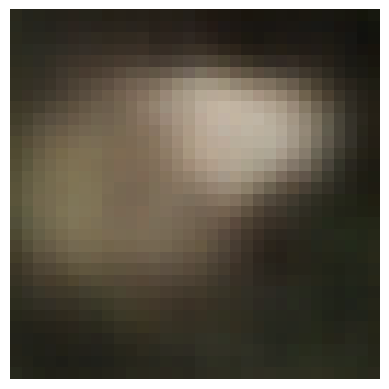

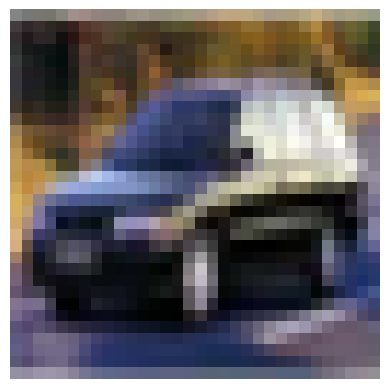

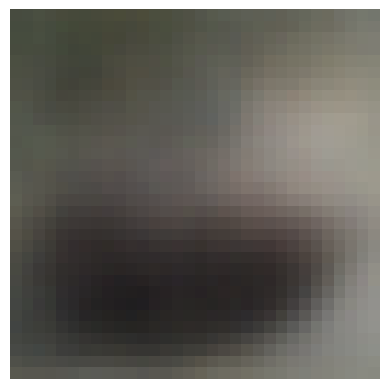

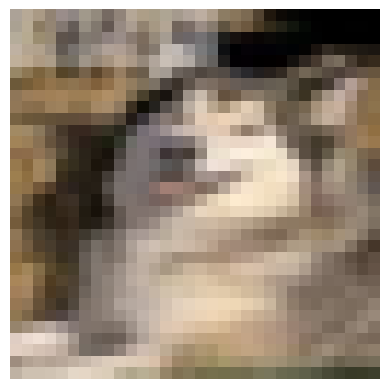

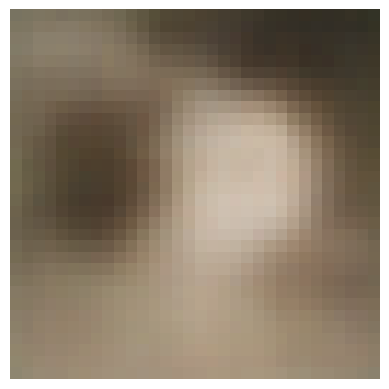

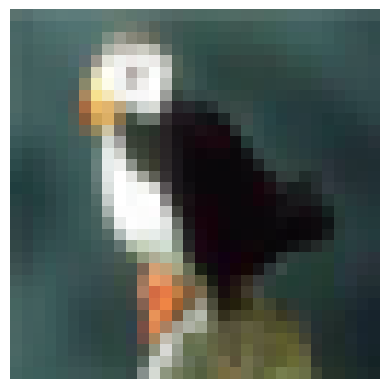

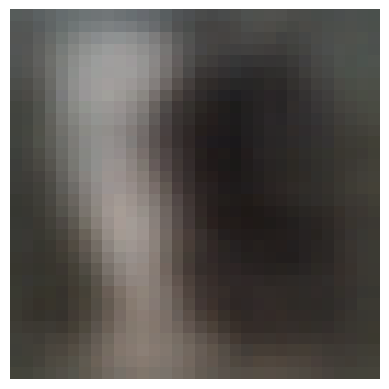

In [26]:
import random

#reconstructing image
for batch, images in enumerate(test_dataloader):
    images = images.cuda()
    tmp = images
    mu_z, log_std_z = model.encoder(tmp).chunk(2, dim = 1)
    z = torch.randn_like(mu_z) * log_std_z.exp() + mu_z
    x_recon = model.decoder(z)
    x_recon = torch.clamp(x_recon, 0, 1)

    x_recon = x_recon.detach().cpu().permute(0, 2, 3, 1).numpy()
    tmp = tmp.detach().cpu().permute(0, 2, 3, 1).numpy()

    rd = random.randint(0, 20)
    plt.imshow(tmp[rd])
    plt.axis('off')  # Turn off axis labels
    plt.show()

    plt.imshow(x_recon[rd])
    plt.axis('off')  # Turn off axis labels
    plt.show()
    
    if (batch == 5): 
        break